In [59]:
import keras
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, UpSampling2D, BatchNormalization, Cropping2D
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Datasets/celeba/images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


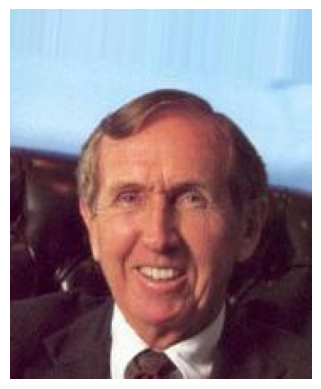

In [111]:
a = cv2.imread(path+'/000021.jpg')
a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

In [26]:
def define_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape= (32, 32, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(LeakyReLU(0.2))


  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


discr = define_discriminator()
print(discr.summary())



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_3 (Dropout)         (None, 131072)            0         
                                                                 
 dense_14 (Dense)            (None, 1)               

In [133]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Dense(8192, input_dim=latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(3, (8, 8), activation='tanh', padding='same'))

  return model



gen = define_generator(100)
print(gen.summary())




Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 8192)              827392    
                                                                 
 leaky_re_lu_290 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_59 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_229 (Conv2  (None, 16, 16, 128)      262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_291 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_transpose_230 (Conv2  (None, 32, 32, 128)      262272    
 DTranspose)                                         

In [46]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


In [38]:
# Preprocessing on Dataset
train_images = []
for filename in os.listdir(path):
  img = cv2.imread(os.path.join(path, filename))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (32, 32))
  train_images.append(img)

train_images = np.array(train_images)

In [41]:
def load_real_samples():

  X = train_images.astype('float32')

  X = (X - 127.5) / 127.5


  return X

In [32]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))

  return X, y

In [33]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [42]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = zeros((n_samples, 1 ))
  return X, y

In [83]:
def train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=6, n_batch=128 ):
  bat_per_epo = int(dataset.shape[0] / n_batch)

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

  g_model.save('/content/drive/MyDrive/Models/celeba_generator_model1.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=32)

In [134]:
test_vector = generate_latent_points(100, 10)

In [135]:
g_model = keras.models.load_model('/content/drive/MyDrive/Models/celeba_generator_model1.h5')
c = g_model.predict(test_vector)

1/1 [==============================] - 0s 142ms/step


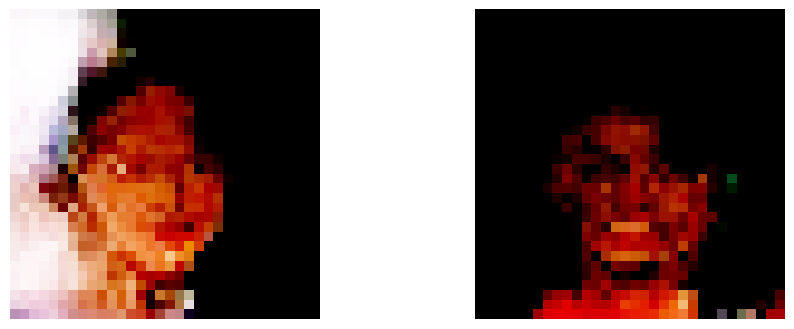

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axs[i].imshow(c[i], cmap='gray')
    axs[i].axis('off')

fig.subplots_adjust(wspace=0.5)
plt.show()